In [ ]:
pwd

In [1]:
%matplotlib inline

import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import PowerNorm
import logging
import frank
from frank.geometry import FitGeometryGaussian, FixedGeometry
from frank.radial_fitters import FrankFitter
from frank.fit import load_default_parameters
from frank.utilities import convolve_profile,make_mock_data, add_vis_noise, UVDataBinner
from frank.make_figs import make_deprojection_fig, make_clean_comparison_fig, make_quick_fig, make_full_fig,make_diag_fig,make_multifit_fig,make_bootstrap_fig
from frank.plot import (
    plot_deprojection_effect,
    plot_brightness_profile,
    plot_vis_quantity,
    plot_vis_hist,
    plot_iterations,
    plot_2dsweep,
    plot_convergence_criterion
) 

frank.enable_logging()

model = load_default_parameters()

u, v, vis, weights = frank.io.load_uvtable('HD163296_continuum_data_ave.txt')

print(u.shape)
print(v.shape)
print(vis.shape)
print(weights.shape)
print(vis)

  Loading UVTable


(2393820,)
(2393820,)
(2393820,)
(2393820,)
[-0.00353453+0.00534885j  0.09289234+0.22157721j  0.14225485-0.01456325j
 ...  0.02054377+0.00113275j -0.03021655-0.02401311j
  0.10415835+0.03227668j]


In [ ]:
%%time

geom = FitGeometryGaussian()
geom.fit(u, v, vis, weights)

print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom.inc, geom.PA,
                                                           geom.dRA*1e3,
                                                           geom.dDec*1e3))

In [2]:
#inc = 46.7 deg
#PA = 133.33 deg
#dRA = -2.8 mas
#dDec = 7.7 mas
geom = FixedGeometry(46.7, 133.33, -2.8e-3, 7.7e-3)

In [ ]:
make_deprojection_fig(u, v, vis, weights, geom, bin_widths=[1e3], figsize=(16,14), force_style=False)

In [3]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.05, 1e-4

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5, max_iter=1e4, store_iteration_diagnostics=True)

sol = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 713

    Convergence criterion met at iteration 713


In [ ]:

bin_widths = [1e3,5e4]
fig, axes = make_quick_fig(u, v, vis, weights,sol2, bin_widths, figsize=(16,16))
#plt.savefig('HD163296_contnium_frank_quick.png')

In [ ]:
HD163296_clean = np.loadtxt('HD163296.profile.txt',skiprows=3)


In [ ]:
import matplotlib.pyplot as plt
plt.plot(HD163296_clean[:,1],HD163296_clean[:,2])

In [1]:
from astropy import units as U
# Load the CLEAN radial profile for AS 209
HD163296_clean = np.loadtxt('HD163296.profile.txt',skiprows=3)
clean_beam = {'bmaj':0.04780, 'bmin':0.03834, 'beam_pa':81.72735}
r_clean, I_clean = HD163296_clean[:,1], HD163296_clean[:,2]
beam_s = np.pi*clean_beam['bmaj']*clean_beam['bmin']/(4*np.log(2))*(U.arcsec.to(U.rad))**2
clean_profile = {'r':r_clean, 'I':I_clean/beam_s, 'lo_err':None, 'hi_err':None}

# Using the same disc geometry parameters as above (the published values)
# and the CLEAN beam parameters from CASA (`imhead` of the published .fits file),
# convolve the frank profile with the CLEAN beam
# Units: [arcsec], [arcsec], [deg]

mean_convolved = convolve_profile(sol.r, sol.mean, geom.inc, geom.PA, clean_beam)

# For the visibility plot, show the observations in 1 and 50 k\lambda bins
bin_widths = [1e3, 5e4]

# And for the 2D representations of the 1D profiles, use a colormap with an arcsinh 
# normalization, including a choice of the arcsinh scale parameter, 'asinh_a'
stretch = 'asinh'
asinh_a = 0.02

# Distance to source [pc] (Andrews et al. 2018), just to show a second x-axis in AU
dist = 101. 

# Zoom in on the lower amplitude visibilities to better see the fit accuracies at long baselines
ylims = [-50, 750]
_,_,clean_DHT=make_clean_comparison_fig(u, v, vis, weights, sol, clean_profile,
                          bin_widths=bin_widths, stretch=stretch, MAP_convolved=mean_convolved, 
                          dist=dist, logx=False,ylims=ylims, force_style=False, figsize=(16,16))
#ax0.legend(fontaize=larage)
#plt.savefig('HD163296_continuum_CLEAN_convolved1.png')

NameError: name 'np' is not defined

In [ ]:
max(sol.I/10**10*(U.rad.to(U.arcsec))**-2)

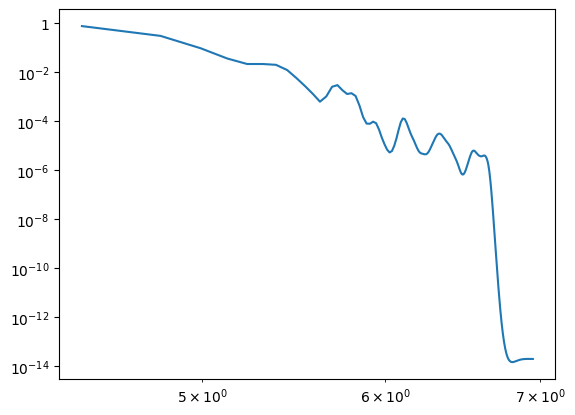

In [51]:
yticks_place = np.arange(0,-15,-2)
yticks = ["1","$10^{-2}$","$10^{-4}$","$10^{-6}$","$10^{-8}$","$10^{-10}$","$10^{-12}$","$10^{-14}$",]
plt.plot(np.log10(sol.q),np.log10(sol.power_spectrum))
plt.yticks(yticks_place,yticks)
plt.xscale('log')

In [ ]:
make_full_fig(u, v, vis, weights, sol, bin_widths,
                  dist=None, logx=False, force_style=True,
                  save_prefix=None, norm_residuals=False, stretch='power',
                  gamma=1.0, asinh_a=0.02, figsize=(16, 16))

In [ ]:
cs = ['#a4a4a4', 'k', '#f781bf', '#dede00']
cs2 = ['#3498DB', '#984ea3', '#4daf4a', '#ff7f00']
hist_cs = ['#377eb8', '#ff7f00', '#e41a1c', '#999999', '#4daf4a', '#f781bf',
           '#984ea3', '#dede00']
multifit_cs = ['#e41a1c', '#999999', '#377eb8', '#ff7f00', '#4daf4a', '#f781bf',
               '#984ea3', '#dede00']
ms = ['x', '+', '.', '1']

fontsize = 25

class _DoNothingContextManager(object):
    def __init__(self, dummy_resource=None):
        self.dummy_resource = dummy_resource
    def __enter__(self):
        return self.dummy_resource
    def __exit__(self, *args):
        pass

def frank_plotting_style_context_manager(use_frank_style=True):
    """Get a context manager for temporary use of frank's own plotting style"""
    if use_frank_style:
        frank_path = os.path.dirname(__file__)
        style_path = os.path.join(frank_path, 'frank.mplstyle')
        return plt.style.context(style_path)
    else:
        return _DoNothingContextManager()

def make_clean_comparison_fig(u, v, vis, weights, sol, clean_profile,
                              bin_widths, stretch='power',
                              gamma=1.0, asinh_a=0.02, MAP_convolved=None,
                              dist=None, logx=False, logy=False, ylims=None,
                              force_style=True, save_prefix=None,
                              figsize=(8, 10)):
    r"""
    Produce a figure comparing a frank fit to a CLEAN fit, in real space by
    convolving the frank fit with the CLEAN beam, and in visibility space by
    taking the discrete Hankel transform of the CLEAN profile

    Parameters
    ----------
    u, v : array, unit = :math:`\lambda`
        u and v coordinates of observations
    vis : array, unit = Jy
        Observed visibilities (complex: real + imag * 1j)
    weights : array, unit = Jy^-2
        Weights assigned to observed visibilities, of the form
        :math:`1 / \sigma^2`
    sol : _HankelRegressor object
        Reconstructed profile using Maximum a posteriori power spectrum
        (see frank.radial_fitters.FrankFitter)
    clean_profile : dict
        Dictionary with entries 'r' for the radial points [arcsec],
        'I' for the brightness [Jy / sr], and optionally the negative and positive
        brightness uncertainties 'lo_err' and 'hi_err' [Jy / sr]. If only the
        negative uncertainty is provided, the positive uncertainty is assumed
        equal to it
    bin_widths : list, unit = \lambda
        Bin widths in which to bin the observed visibilities
    stretch : string, default = 'power'
        Transformation to apply to the colorscale. The default 'power' is a
        power law stretch. The other option is 'asinh', an arcsinh stretch,
        which requires astropy.visualization.mpl_normalize.simple_norm
    gamma : float, default = 1.0
        Index of power law normalization to apply to swept profile image's
        colormap (see matplotlib.colors.PowerNorm).
        gamma=1.0 yields a linear colormap
    asinh_a : float, default = 0.02
        Scale parameter for an asinh stretch
    MAP_convolved : None (default) or array, unit = Jy / sr
        frank brightness profile convolved with a CLEAN beam
        (see utilities.convolve_profile).
        The assumed unit is for the x-label
    dist : float, optional, unit = AU, default = None
        Distance to source, used to show second x-axis in [AU]
    logx : bool, default = False
        Whether to plot the visibility distributions in log(baseline)
    logy : bool, default = False
        Whether to plot the visibility distributions in log(flux)
    ylims : list of len(2), default = None
        Lower and upper y-bounds for the visibility domain plot
    force_style: bool, default = True
        Whether to use preconfigured matplotlib rcParams in generated figure
    save_prefix : string, default = None
        Prefix for saved figure name. If None, the figure won't be saved
    figsize : tuple = (width, height) of figure, unit = inch

    Returns
    -------
    fig : Matplotlib `.Figure` instance
        The produced figure, including the GridSpec
    axes : Matplotlib `~.axes.Axes` class
        The axes of the produced figure
    """

    logging.info('    Making CLEAN comparison figure')

    with frank_plotting_style_context_manager(force_style):
        gs = GridSpec(3, 1)
        gs2 = GridSpec(3, 3)

        fig = plt.figure(figsize=figsize)

        ax0 = fig.add_subplot(gs[0])
        ax1 = fig.add_subplot(gs[1])

        ax2 = fig.add_subplot(gs2[6])
        ax3 = fig.add_subplot(gs2[7])
        ax4 = fig.add_subplot(gs2[8])

        axes = [ax0, ax1, ax2, ax3, ax4]

        if 'lo_err' in clean_profile.keys():
            low_uncer = clean_profile['lo_err']
        else:
            low_uncer = None
        if 'hi_err' in clean_profile.keys():
            high_uncer = clean_profile['hi_err']
        else:
            high_uncer = None

        plot_brightness_profile(clean_profile['r'], clean_profile['I'] / 1e10, ax0,
                                low_uncer=low_uncer, high_uncer=high_uncer,
                                c='b', ls='--', label='CLEAN')

        plot_brightness_profile(sol.r, sol.I / 1e10, ax0, c='r', ls=':', label='frank')

        if MAP_convolved is not None:
            plot_brightness_profile(sol.r, MAP_convolved / 1e10, ax0, c='k', ls='-',
                                    label='frank, convolved')

        if dist:
            ax0_5 = plot_brightness_profile(sol.r, sol.I / 1e10, ax0, dist=dist, c='r', ls=':')

        u_deproj, v_deproj, vis_deproj = sol.geometry.apply_correction(u, v, vis)
        baselines = (u_deproj**2 + v_deproj**2)**.5
        grid = np.logspace(np.log10(min(baselines.min(), sol.q[0])),
                           np.log10(max(baselines.max(), sol.q[-1])), 10**4
                           )

        for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, weights, bin_widths[i])
            vis_re = binned_vis.V.real * 1e3
            vis_err_re = binned_vis.error.real * 1e3

            if logy:
                lab=r'Obs.>0, {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3)
            else:
                lab=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3)
            plot_vis_quantity(binned_vis.uv / 1e6, vis_re, ax1, c=cs[i],
                     marker=ms[i], ls='None',
                     label=lab)
            if logy:
                plot_vis_quantity(binned_vis.uv / 1e6, -vis_re, ax1, c=cs2[i],
                     marker=ms[i], ls='None',
                     label=r'Obs.<0, {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))

        vis_fit = sol.predict_deprojected(grid).real * 1e3

        # Take the discrete Hankel transform of the CLEAN profile, using the same
        # collocation points for the DHT as those in the frank fit
        Inu_interp = np.interp(
            sol.r, clean_profile['r'], clean_profile['I'].real) * 1e3
        clean_DHT = sol.predict_deprojected(grid, I=Inu_interp)

        if logy:
            lab = 'frank, >0'
            lab2 = 'DHT of CLEAN, >0'
        else:
            lab = 'frank'
            lab2 = 'DHT of CLEAN'
        plot_vis_quantity(grid / 1e6, vis_fit, ax1, c='r', label=lab)
        plot_vis_quantity(grid / 1e6, clean_DHT, ax1, c='b', label=lab2)
        if logy:
            plot_vis_quantity(grid / 1e6, -vis_fit, ax1, c='r', ls='--', label='frank, <0')
            plot_vis_quantity(grid / 1e6, -clean_DHT, ax1, c='b', ls='--', label='DHT of CLEAN, <0')

        if logx:
            ax1.set_xscale('log')
        ax1.set_xlim(right=1.2 * max(baselines) / 1e6)

        if logy:
            ax1.set_yscale('log')
            ax1.set_ylim(bottom=1e-3)
        if ylims:
            ax1.set_ylim(ylims)

        if MAP_convolved is not None:
            vmax = max(sol.I.max(), MAP_convolved.max(), clean_profile['I'].max())
        else:
            vmax = max(sol.I.max(), clean_profile['I'].max())
        if stretch == 'asinh':
            vmin = max(0, min(sol.I))
            from astropy.visualization.mpl_normalize import simple_norm
            norm = simple_norm(sol.I, stretch='asinh', asinh_a=asinh_a, 
                               min_cut=vmin, max_cut=vmax)
        elif stretch == 'power':
            vmin = 0
            norm = PowerNorm(gamma, vmin, vmax)
        else:
            err = ValueError("Unknown 'stretch'. Should be one of 'power' or 'asinh'")
            raise err

        plot_2dsweep(sol.r, sol.I, ax=ax2, cmap='inferno', norm=norm,
                    xmax=sol.Rmax, plot_colorbar=True)
        if MAP_convolved is not None:
            plot_2dsweep(sol.r, MAP_convolved, ax=ax3, cmap='inferno', norm=norm,
                        xmax=sol.Rmax, plot_colorbar=True)

        # Interpolate the CLEAN profile onto the frank grid to ensure the CLEAN
        # swept 'image' has the same pixel resolution as the frank swept 'images'
        from scipy.interpolate import interp1d
        interp = interp1d(clean_profile['r'], clean_profile['I'])
        regrid_I_clean = interp(sol.r)
        plot_2dsweep(sol.r, regrid_I_clean, ax=ax4, cmap='inferno', norm=norm,
                    xmax=sol.Rmax, plot_colorbar=True)

        ax0.legend(loc='best',fontsize=fontsize-5)
        ax1.legend(loc='best', ncol=2,fontsize=fontsize-7)

        ax0.set_xlabel('r ["]',fontsize="x-large")
        ax0.set_ylabel(r'Brightness [$10^{10}$ Jy sr$^{-1}$]',fontsize=fontsize-5)
        ax1.set_xlabel(r'Baseline [M$\lambda$]',fontsize=fontsize)
        ax1.set_ylabel(r'Re(V) [mJy]',fontsize=fontsize)
        ax2.set_xlabel('RA offset ["]')
        ax3.set_xlabel('RA offset ["]')
        ax4.set_xlabel('RA offset ["]')
        ax2.set_ylabel('Dec offset ["]')

        plt.setp(ax0.get_xticklabels(),fontsize=fontsize-5)
        plt.setp(ax0.get_yticklabels(),fontsize=fontsize-5)
        plt.setp(ax1.get_xticklabels(),fontsize=fontsize-5)
        plt.setp(ax1.get_yticklabels(),fontsize=fontsize-5)
        
        ax0.set_xlim(right=sol.Rmax)
        if dist:
            xlims = ax0.get_xlim()
            ax0_5.set_xlim(np.multiply(xlims, dist))

        if logx:
            ax1.set_xscale('log')
        if logy:
            ax1.set_yscale('log')
            ax1.set_ylim(bottom=1e-3)

        #ax2.set_title('Unconvolved frank profile swept')
        #ax3.set_title('Convolved frank profile swept')
        #ax4.set_title('CLEAN profile swept')

        ax0.text(.5, .9, 'a)', transform=ax0.transAxes)
        ax1.text(.5, .9, 'b)', transform=ax1.transAxes)
        ax2.text(.1, .9, 'c)', c='w', transform=ax2.transAxes)
        ax3.text(.1, .9, 'd)', c='w', transform=ax3.transAxes)
        ax4.text(.1, .9, 'e)', c='w', transform=ax4.transAxes)

        

        if save_prefix:
            plt.savefig(save_prefix + '_frank_clean_comparison.png', dpi=300)
            plt.close()

    return fig, axes
_,_,=make_clean_comparison_fig(u, v, vis, weights, sol, clean_profile,
                    bin_widths=bin_widths, stretch=stretch, MAP_convolved=mean_convolved, 
                    dist=dist, logx=False,ylims=ylims, force_style=False, figsize=(16,16))
#plt.savefig('HD163296_continuum_CLEAN_convolved.png')

In [5]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.3, 1e-4

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol1 = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 277

    Convergence criterion met at iteration 277


In [4]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.5, 1e-4

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol2 = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 127

    Convergence criterion met at iteration 127


In [7]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.05, 1e-2

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol3 = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 554

    Convergence criterion met at iteration 554


In [8]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.3, 1e-2

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol4 = FF.fit(u, v, vis, weights)


  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 170


    Convergence criterion met at iteration 170


In [9]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.5, 1e-2

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol5 = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 102

    Convergence criterion met at iteration 102


In [5]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.05, 1e0

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol6 = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 184


    Convergence criterion met at iteration 184


In [11]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.3, 1e0

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol7 = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 243

    Convergence criterion met at iteration 243


In [6]:
Rmax, N, alpha, weights_smooth = 2.9, 250, 1.5, 1e0

FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth = weights_smooth, block_size=1e5)

sol8 = FF.fit(u, v, vis, weights)

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: Normal method
    Building visibility matrices M and j


    FrankFitter iteration 97

    Convergence criterion met at iteration 97


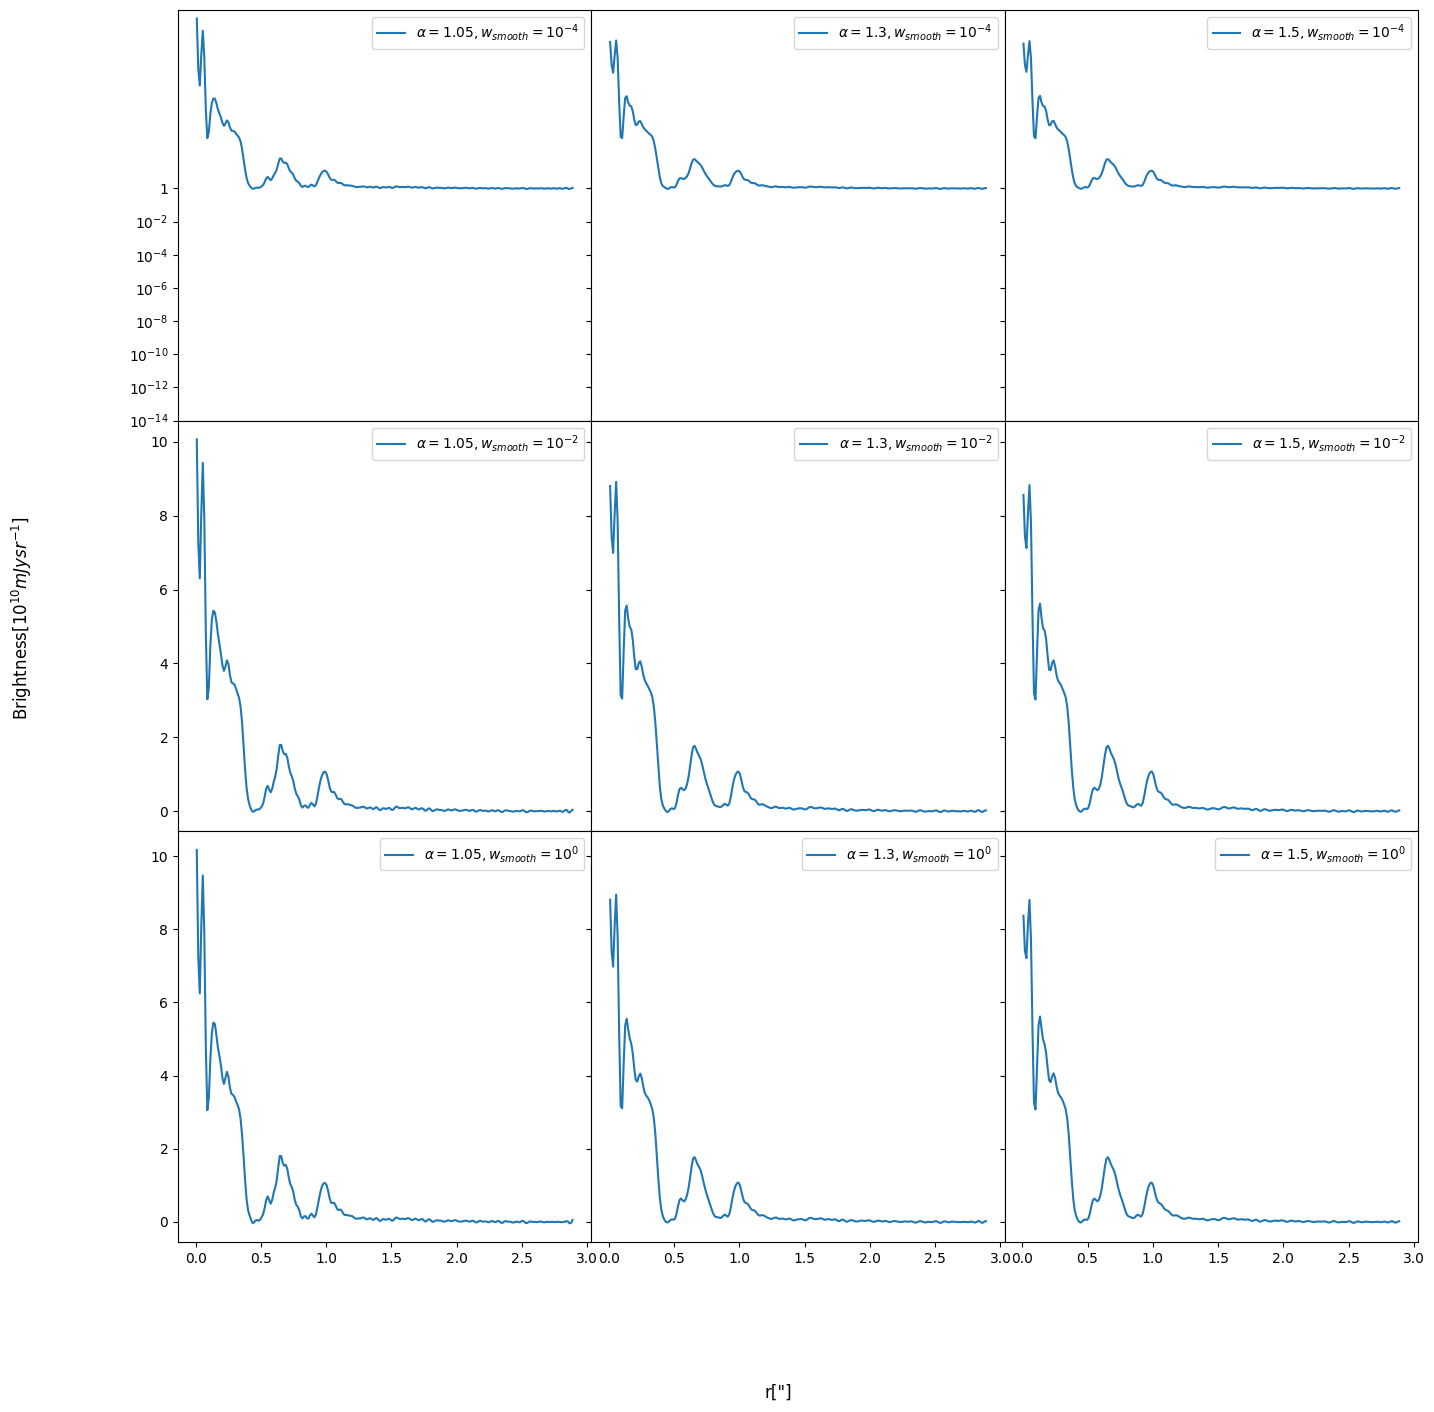

In [52]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16,16))

gs = gridspec.GridSpec(3,3)
fontsize = 25
inposi =[0.5,0.3,0.5,0.5]

ax1=plt.subplot(gs[0,0])
ax2=plt.subplot(gs[0,1],sharey=ax1)
ax3=plt.subplot(gs[0,2],sharey=ax1)
ax4=plt.subplot(gs[1,0],sharex=ax1)
ax5=plt.subplot(gs[1,1],sharex=ax2,sharey=ax4)
ax6=plt.subplot(gs[1,2],sharex=ax3,sharey=ax4)
ax7=plt.subplot(gs[2,0],sharex=ax1)
ax8=plt.subplot(gs[2,1],sharex=ax2,sharey=ax7)
ax9=plt.subplot(gs[2,2],sharex=ax3,sharey=ax7)

ax1.plot(sol.r,sol.I/1e10)
ax1.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{-4}$"])

ax2.plot(sol1.r,sol1.I/1e10)
ax2.legend(labels=[r"$\alpha=1.3,w_{smooth}=10^{-4}$"])

ax3.plot(sol2.r,sol2.I/1e10)
ax3.legend(labels=[r"$\alpha=1.5,w_{smooth}=10^{-4}$"])

ax4.plot(sol3.r,sol3.I/1e10)
ax4.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{-2}$"])

ax5.plot(sol4.r,sol4.I/1e10)
ax5.legend(labels=[r"$\alpha=1.3,w_{smooth}=10^{-2}$"])

ax6.plot(sol5.r,sol5.I/1e10)
ax6.legend(labels=[r"$\alpha=1.5,w_{smooth}=10^{-2}$"])

ax7.plot(sol6.r,sol6.I/1e10)
ax7.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{0}$"])

ax8.plot(sol7.r,sol7.I/1e10)
ax8.legend(labels=[r"$\alpha=1.3,w_{smooth}=10^{0}$"])

ax9.plot(sol8.r,sol8.I/1e10)
ax9.legend(labels=[r"$\alpha=1.5,w_{smooth}=10^{0}$"])

fig.supylabel("Brightness[$10^{10}mJy sr^{-1}$]")
fig.supxlabel('r["]')

plt.setp(ax1.get_xticklabels(),visible=False)
plt.setp(ax3.get_xticklabels(),visible=False)
plt.setp(ax6.get_xticklabels(),visible=False)
plt.setp(ax2.get_yticklabels(),visible=False)
plt.setp(ax3.get_yticklabels(),visible=False)
plt.setp(ax5.get_yticklabels(),visible=False)
plt.setp(ax6.get_yticklabels(),visible=False)
plt.setp(ax8.get_yticklabels(),visible=False)
plt.setp(ax9.get_yticklabels(),visible=False)

'''
plt.setp(ax1.get_yticklabels())
plt.setp(ax4.get_xticklabels())
'''
'''
axins1= ax1.inset_axes(inposi)
axins1.plot(sol.r,sol.I/1e10,lw=3)
axins1.set_xlim(0.3,1.5)
axins1.set_ylim(0,2)
ax1.indicate_inset_zoom(axins1)

axins2= ax2.inset_axes(inposi)
axins2.plot(sol1.r,sol1.I/1e10,lw=3)
axins2.set_xlim(0.3,1.5)
axins2.set_ylim(0,2)
ax2.indicate_inset_zoom(axins2)

axins3= ax3.inset_axes(inposi)
axins3.plot(sol2.r,sol2.I/1e10,lw=3)
axins3.set_xlim(0.3,1.5)
axins3.set_ylim(0,2)
ax3.indicate_inset_zoom(axins3)

axins4= ax4.inset_axes(inposi)
axins4.plot(sol3.r,sol3.I/1e10,lw=3)
axins4.set_xlim(0.3,1.5)
axins4.set_ylim(0,2)
ax4.indicate_inset_zoom(axins4)
'''
plt.subplots_adjust(wspace=.0,hspace=.0)
#plt.savefig('HD163296_contnium_alpha_smooth1.png')

<>:51: SyntaxWarning: invalid escape sequence '\l'
<>:51: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narks\AppData\Local\Temp\ipykernel_37300\1311354119.py:51: SyntaxWarning: invalid escape sequence '\l'
  fig.supxlabel("Baseline[$\lambda$]")


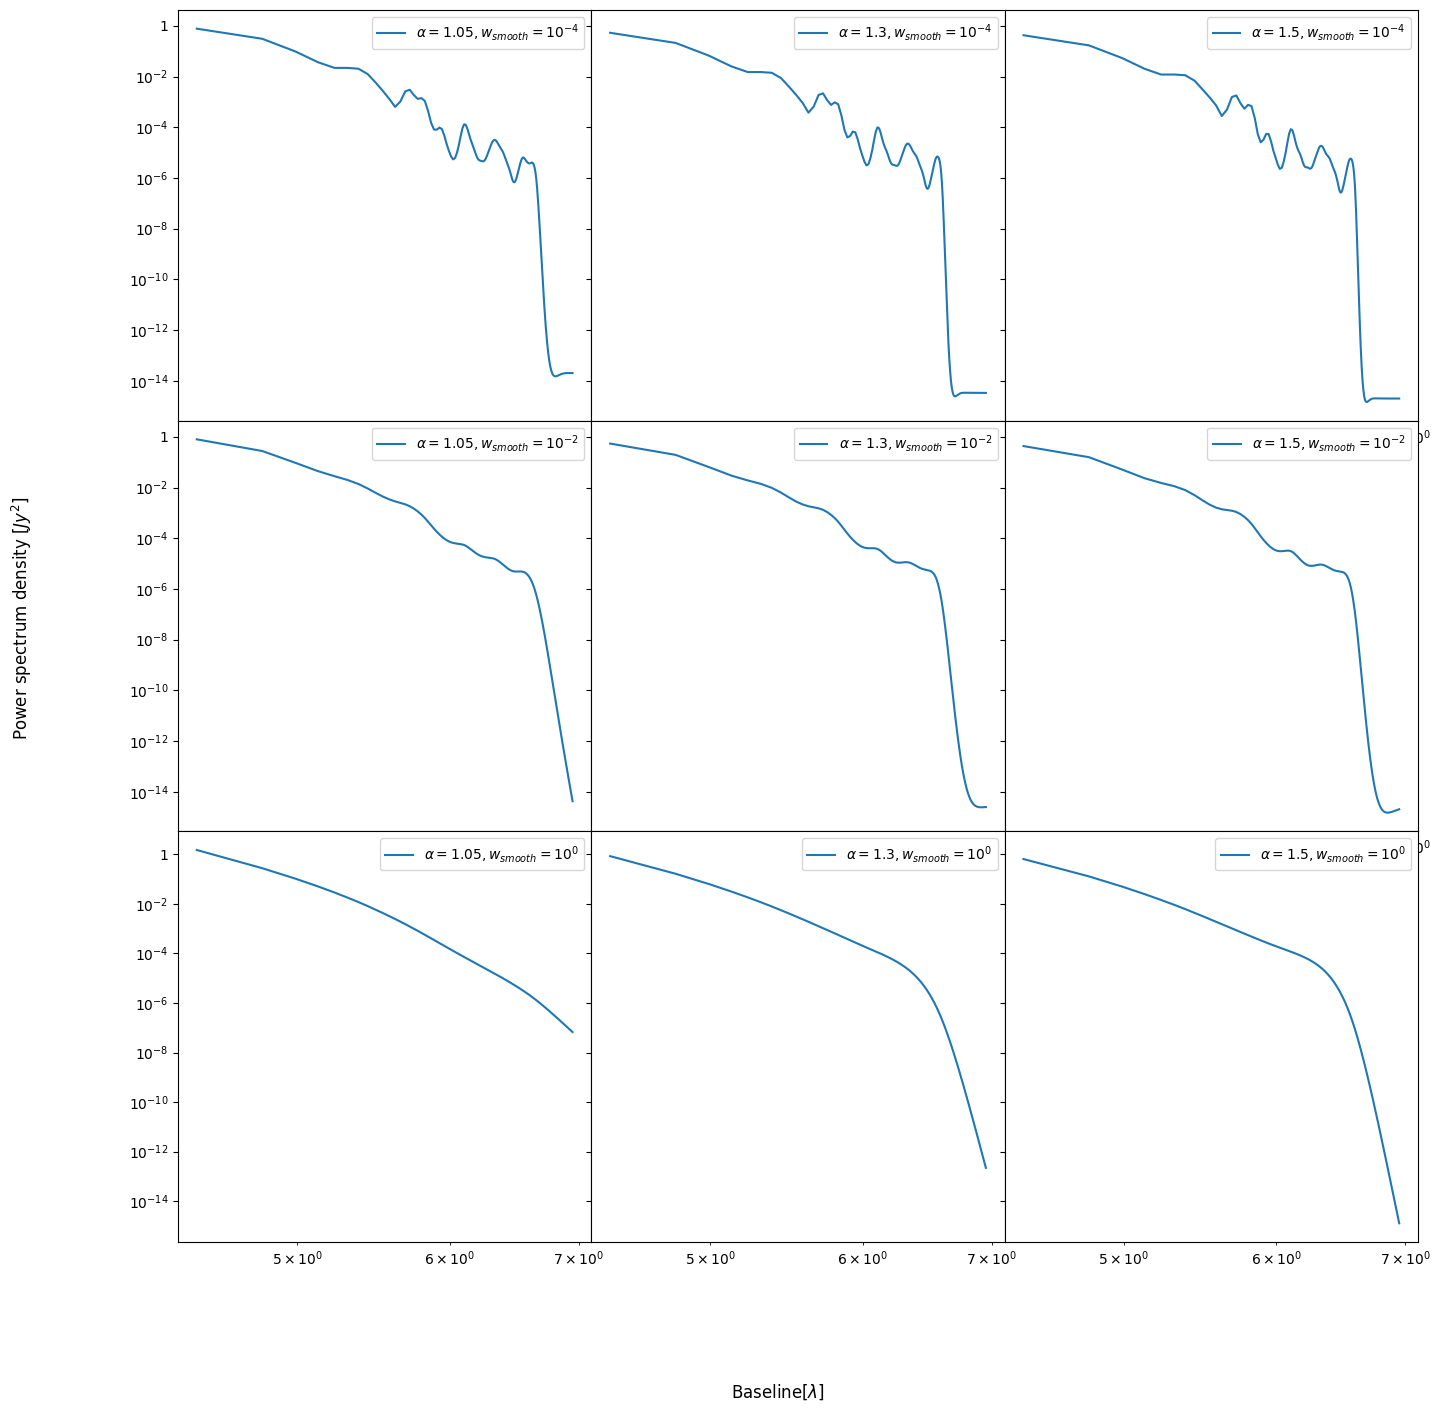

In [64]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16,16))

gs = gridspec.GridSpec(3,3)
fontsize = 25
inposi =[0.5,0.3,0.5,0.5]

ax1=plt.subplot(gs[0,0])
ax2=plt.subplot(gs[0,1],sharey=ax1)
ax3=plt.subplot(gs[0,2],sharey=ax1)
ax4=plt.subplot(gs[1,0],sharex=ax1)
ax5=plt.subplot(gs[1,1],sharex=ax2,sharey=ax4)
ax6=plt.subplot(gs[1,2],sharex=ax3,sharey=ax4)
ax7=plt.subplot(gs[2,0],sharex=ax1)
ax8=plt.subplot(gs[2,1],sharex=ax2,sharey=ax7)
ax9=plt.subplot(gs[2,2],sharex=ax3,sharey=ax7)


ax1.plot(np.log10(sol.q),np.log10(sol.power_spectrum))
ax1.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{-4}$"])
ax1.set_xscale('log')

ax2.plot(np.log10(sol1.q),np.log10(sol1.power_spectrum))
ax2.legend(labels=[r"$\alpha=1.3,w_{smooth}=10^{-4}$"])
ax2.set_xscale('log')

ax3.plot(np.log10(sol2.q),np.log10(sol2.power_spectrum))
ax3.legend(labels=[r"$\alpha=1.5,w_{smooth}=10^{-4}$"])
ax3.set_xscale('log')

ax4.plot(np.log10(sol3.q),np.log10(sol3.power_spectrum))
ax4.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{-2}$"])

ax5.plot(np.log10(sol4.q),np.log10(sol4.power_spectrum))
ax5.legend(labels=[r"$\alpha=1.3,w_{smooth}=10^{-2}$"])

ax6.plot(np.log10(sol5.q),np.log10(sol5.power_spectrum))
ax6.legend(labels=[r"$\alpha=1.5,w_{smooth}=10^{-2}$"])

ax7.plot(np.log10(sol6.q),np.log10(sol6.power_spectrum))
ax7.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{0}$"])

ax8.plot(np.log10(sol7.q),np.log10(sol7.power_spectrum))
ax8.legend(labels=[r"$\alpha=1.3,w_{smooth}=10^{0}$"])

ax9.plot(np.log10(sol8.q),np.log10(sol8.power_spectrum))
ax9.legend(labels=[r"$\alpha=1.5,w_{smooth}=10^{0}$"])

fig.supylabel("Power spectrum density [$Jy^2$]")
fig.supxlabel("Baseline[$\lambda$]")

plt.setp(ax1.get_xticklabels(),visible=False)
plt.setp(ax7.get_xticklabels(),visible=False)
plt.setp(ax6.get_xticklabels(),visible=False)
plt.setp(ax2.get_yticklabels(),visible=False)
plt.setp(ax3.get_yticklabels(),visible=False)
plt.setp(ax5.get_yticklabels(),visible=False)
plt.setp(ax6.get_yticklabels(),visible=False)
plt.setp(ax8.get_yticklabels(),visible=False)
plt.setp(ax9.get_yticklabels(),visible=False)

ax7.set_xticks([])
ax1.set_yticks(yticks_place)
ax1.set_yticklabels(yticks)
ax4.set_yticks(yticks_place)
ax4.set_yticklabels(yticks)
ax7.set_yticks(yticks_place)
ax7.set_yticklabels(yticks)
'''
plt.setp(ax1.get_yticklabels())
plt.setp(ax4.get_xticklabels())
'''
'''
axins1= ax1.inset_axes(inposi)
axins1.plot(sol.r,sol.I/1e10,lw=3)
axins1.set_xlim(0.3,1.5)
axins1.set_ylim(0,2)
ax1.indicate_inset_zoom(axins1)

axins2= ax2.inset_axes(inposi)
axins2.plot(sol1.r,sol1.I/1e10,lw=3)
axins2.set_xlim(0.3,1.5)
axins2.set_ylim(0,2)
ax2.indicate_inset_zoom(axins2)

axins3= ax3.inset_axes(inposi)
axins3.plot(sol2.r,sol2.I/1e10,lw=3)
axins3.set_xlim(0.3,1.5)
axins3.set_ylim(0,2)
ax3.indicate_inset_zoom(axins3)

axins4= ax4.inset_axes(inposi)
axins4.plot(sol3.r,sol3.I/1e10,lw=3)
axins4.set_xlim(0.3,1.5)
axins4.set_ylim(0,2)
ax4.indicate_inset_zoom(axins4)
'''
plt.subplots_adjust(wspace=.0,hspace=.0)
plt.savefig('HD163296_contnium_alpha_smooth2.png')

In [3]:
import numpy as np
from astropy import units as U
# Load the CLEAN radial profile for AS 209
#HD163296_clean = np.loadtxt('HD163296.profile.txt',skiprows=3)
clean_beam = {'bmaj':0.04780, 'bmin':0.03834, 'beam_pa':81.72735}
#r_clean, I_clean = HD163296_clean[:,1], HD163296_clean[:,2]
beam_s = np.pi*clean_beam['bmaj']*clean_beam['bmin']/(4*np.log(2))*(U.arcsec.to(U.rad))**2
#clean_profile = {'r':r_clean, 'I':I_clean/beam_s, 'lo_err':None, 'hi_err':None}
beam_s

np.float64(4.8808353691036406e-14)

<>:33: SyntaxWarning: invalid escape sequence '\l'
<>:33: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narks\AppData\Local\Temp\ipykernel_3060\198839778.py:33: SyntaxWarning: invalid escape sequence '\l'
  fig.supxlabel('Baseline[$\lambda$]',fontsize=fontsize)


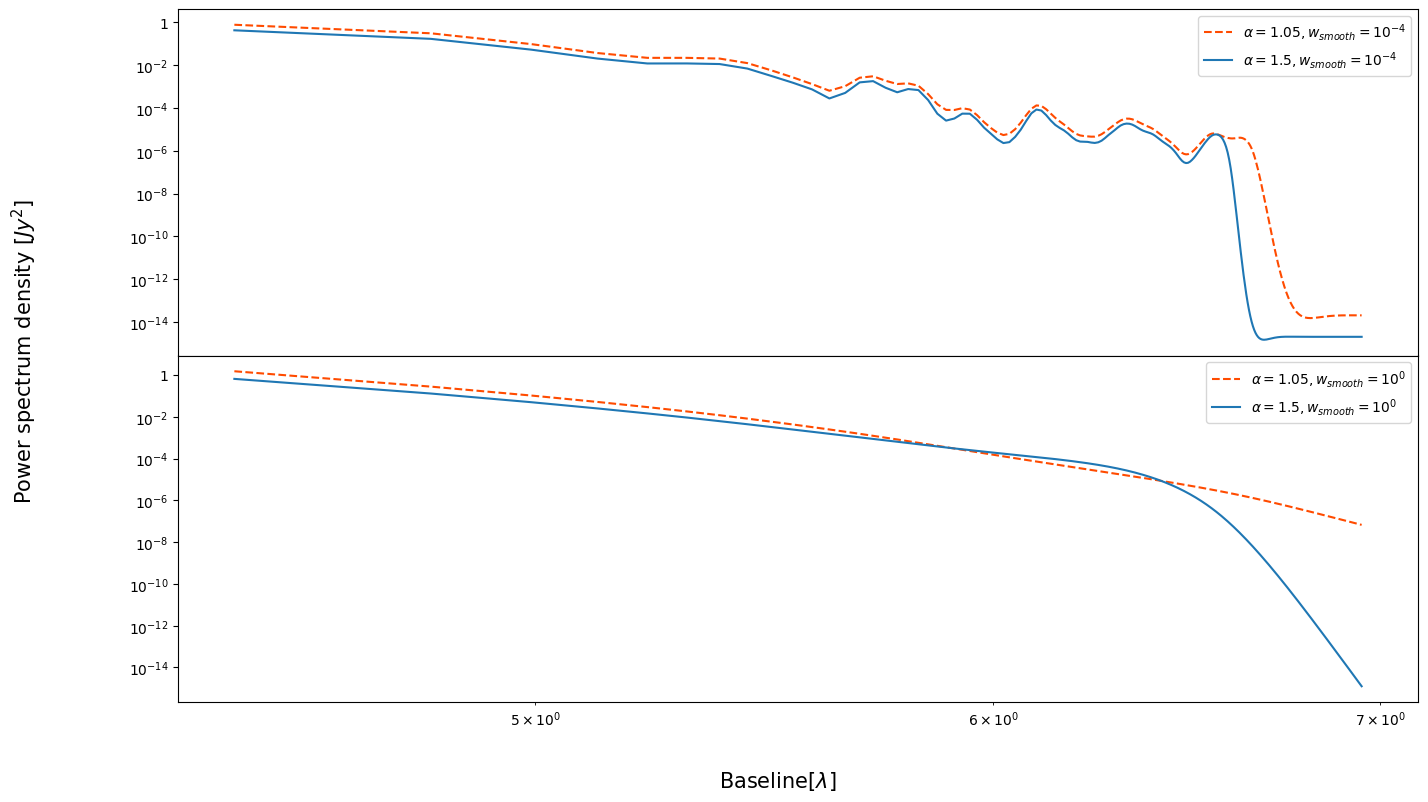

In [32]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16,9))
yticks_place = np.arange(0,-15,-2)
yticks = ["1","$10^{-2}$","$10^{-4}$","$10^{-6}$","$10^{-8}$","$10^{-10}$","$10^{-12}$","$10^{-14}$",]

gs = gridspec.GridSpec(2,1)
fontsize = 15
inposi =[0.5,0.3,0.5,0.5]

ax1=plt.subplot(gs[0,0])
ax2=plt.subplot(gs[1,0],sharex=ax1)

ax1.plot(np.log10(sol.q),np.log10(sol.power_spectrum),color = "#FF4B00",linestyle ="--")
ax1.plot(np.log10(sol2.q),np.log10(sol2.power_spectrum))
ax1.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{-4}$",r"$\alpha=1.5,w_{smooth}=10^{-4}$"])
ax1.set_xscale('log')

ax2.plot(np.log10(sol6.q),np.log10(sol6.power_spectrum),color = "#FF4B00",linestyle = "--")
ax2.plot(np.log10(sol8.q),np.log10(sol8.power_spectrum))
ax2.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{0}$",r"$\alpha=1.5,w_{smooth}=10^{0}$"])
ax2.set_xscale('log')

plt.setp(ax1.get_xticklabels(),visible=False)

ax1.set_yticks(yticks_place)
ax1.set_yticklabels(yticks)
ax2.set_yticks(yticks_place)
ax2.set_yticklabels(yticks)

plt.subplots_adjust(wspace=.0,hspace=.0)
fig.supylabel("Power spectrum density [$Jy^2$]", fontsize=fontsize)
fig.supxlabel('Baseline[$\lambda$]',fontsize=fontsize)
plt.savefig('HD163296_contnium_alpha_smoothpp2.png')

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
C:\Users\narks\AppData\Local\Temp\ipykernel_3060\118436120.py:23: SyntaxWarning: invalid escape sequence '\l'
  fig.supxlabel('Baseline[$\lambda$]',fontsize=fontsize)


Text(0.5, 0.01, 'Baseline[$\\lambda$]')

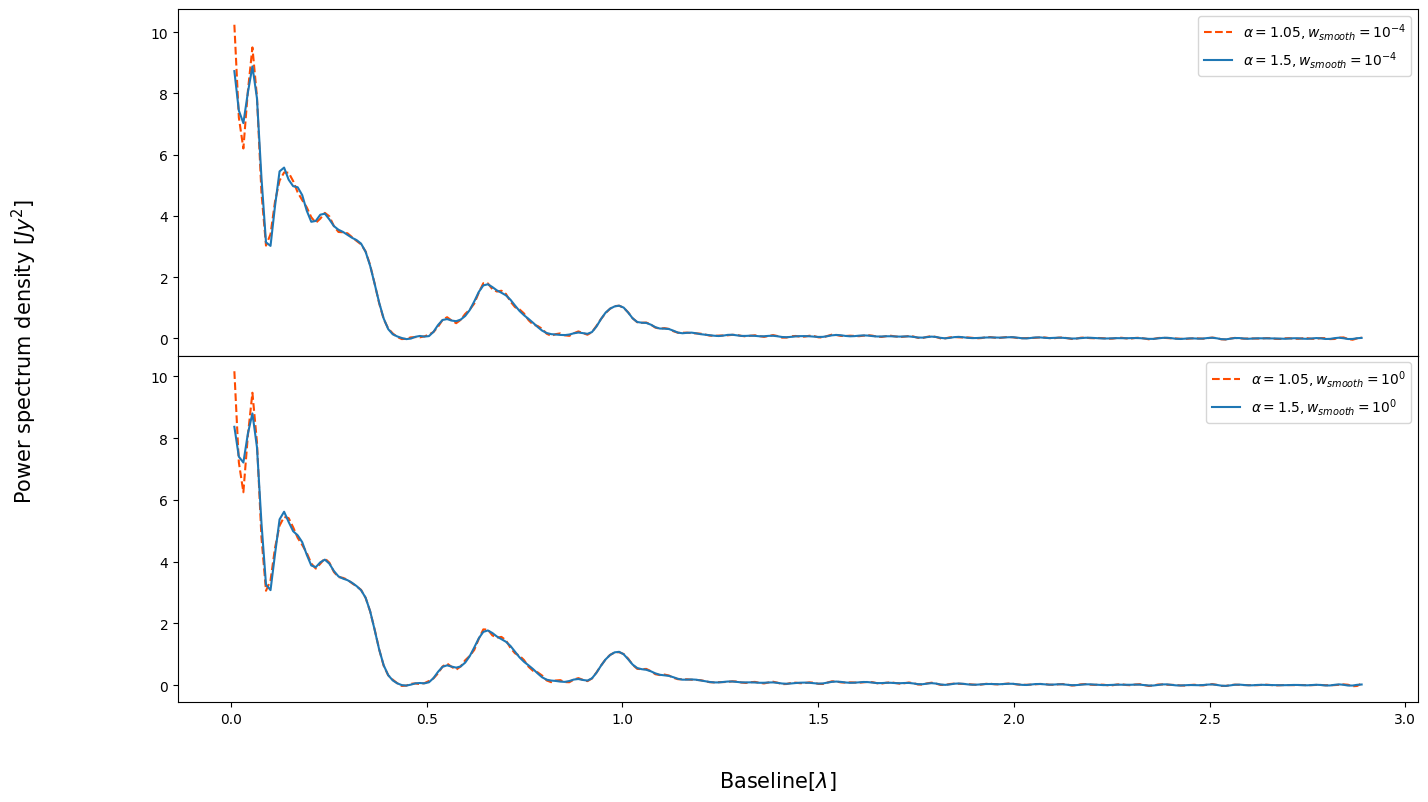

In [28]:
fig = plt.figure(figsize=(16,9))

gs = gridspec.GridSpec(2,1)
fontsize = 15
inposi =[0.5,0.3,0.5,0.5]

ax1=plt.subplot(gs[0,0])
ax2=plt.subplot(gs[1,0],sharex=ax1)

ax1.plot(sol.r,sol.I/1e10,color = "#FF4B00",linestyle ="--")
ax1.plot(sol2.r,sol2.I/1e10)
ax1.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{-4}$",r"$\alpha=1.5,w_{smooth}=10^{-4}$"])

ax2.plot(sol6.r,sol6.I/1e10,color = "#FF4B00",linestyle = "--")
ax2.plot(sol8.r,sol8.I/1e10)
ax2.legend(labels=[r"$\alpha=1.05,w_{smooth}=10^{0}$",r"$\alpha=1.5,w_{smooth}=10^{0}$"])

plt.setp(ax1.get_xticklabels(),visible=False)

plt.subplots_adjust(wspace=.0,hspace=.0)

fig.supylabel("Power spectrum density [$Jy^2$]", fontsize=fontsize)
fig.supxlabel('Baseline[$\lambda$]',fontsize=fontsize)
#plt.savefig('HD163296_contnium_alpha_smoothpp2.png')